https://www.datacamp.com/community/tutorials/autoencoder-classifier-python#conv

**Autoencoder as a Classifier using Fashion-MNIST Dataset**

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# Check shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [5]:
# To keep it consistent with tutorial, rename X_train, X_test

train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test


In [6]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: E)')

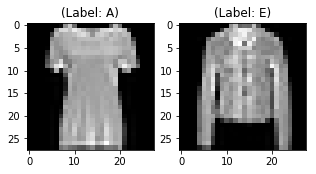

In [7]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

Data Preprocessing

In [8]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
# Rescale
np.max(train_data), np.max(test_data)

(255, 255)

In [10]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [11]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

Convolutional Autoencoder

In [12]:
batch_size = 64
epochs = 10 #200 originally
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [13]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [14]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [16]:
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 29s 595us/step - loss: 0.0198 - val_loss: 0.0117
Epoch 2/10
48000/48000 [==============================] - 26s 550us/step - loss: 0.0088 - val_loss: 0.0082
Epoch 3/10
48000/48000 [==============================] - 26s 551us/step - loss: 0.0073 - val_loss: 0.0067
Epoch 4/10
48000/48000 [==============================] - 26s 550us/step - loss: 0.0059 - val_loss: 0.0066
Epoch 5/10
48000/48000 [==============================] - 26s 550us/step - loss: 0.0052 - val_loss: 0.0070
Epoch 6/10
48000/48000 [==============================] - 27s 555us/step - loss: 0.0046 - val_loss: 0.0049
Epoch 7/10
48000/48000 [==============================] - 27s 552us/step - loss: 0.0043 - val_loss: 0.0045
Epoch 8/10
48000/48000 [==============================] - 26s 549us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 9/10
48000/48000 [==============================] - 26s 551us/step - loss: 0.0036 - val_

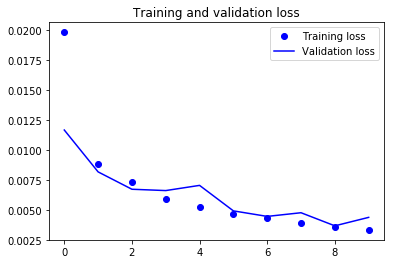

In [19]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
autoencoder.save_weights('autoencoder.h5')

In [21]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [22]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [23]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [24]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [25]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [26]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [27]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [28]:
autoencoder.get_weights()[0][1]

array([[[-0.07811468,  0.09336099, -0.12764718,  0.05419917,
          0.09635516, -0.01284702,  0.1403355 , -0.01583075,
          0.03178925, -0.05025292, -0.00251058, -0.01706373,
         -0.09555789,  0.03454546,  0.04243634,  0.18273793,
         -0.13660501, -0.05877271,  0.09981906, -0.14476095,
          0.12381068, -0.15087038,  0.0829404 , -0.02974454,
          0.22292514, -0.09516361, -0.07959434,  0.07712369,
         -0.2658283 , -0.05511539, -0.1466306 ,  0.00920593]],

       [[-0.15694295, -0.15630913,  0.02609293,  0.1800793 ,
          0.35994896, -0.08558783,  0.22592348,  0.07665882,
          0.31189114, -0.17254844,  0.06595726,  0.18328854,
         -0.06308628, -0.08540761, -0.13777319, -0.03774893,
          0.02036517, -0.18824956, -0.03393364,  0.18812639,
          0.17026831,  0.08793513, -0.19595726, -0.03371558,
         -0.15248679,  0.11912645,  0.12387899,  0.13658756,
         -0.18167715, -0.1140554 , -0.11983601, -0.02718453]],

       [[-0.091810

In [29]:
full_model.get_weights()[0][1]

array([[[-0.07811468,  0.09336099, -0.12764718,  0.05419917,
          0.09635516, -0.01284702,  0.1403355 , -0.01583075,
          0.03178925, -0.05025292, -0.00251058, -0.01706373,
         -0.09555789,  0.03454546,  0.04243634,  0.18273793,
         -0.13660501, -0.05877271,  0.09981906, -0.14476095,
          0.12381068, -0.15087038,  0.0829404 , -0.02974454,
          0.22292514, -0.09516361, -0.07959434,  0.07712369,
         -0.2658283 , -0.05511539, -0.1466306 ,  0.00920593]],

       [[-0.15694295, -0.15630913,  0.02609293,  0.1800793 ,
          0.35994896, -0.08558783,  0.22592348,  0.07665882,
          0.31189114, -0.17254844,  0.06595726,  0.18328854,
         -0.06308628, -0.08540761, -0.13777319, -0.03774893,
          0.02036517, -0.18824956, -0.03393364,  0.18812639,
          0.17026831,  0.08793513, -0.19595726, -0.03371558,
         -0.15248679,  0.11912645,  0.12387899,  0.13658756,
         -0.18167715, -0.1140554 , -0.11983601, -0.02718453]],

       [[-0.091810

In [30]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [31]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [32]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [33]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 226us/step - loss: 0.3971 - acc: 0.8628 - val_loss: 0.3193 - val_acc: 0.8866
Epoch 2/10
48000/48000 [==============================] - 10s 208us/step - loss: 0.2596 - acc: 0.9035 - val_loss: 0.3170 - val_acc: 0.8942
Epoch 3/10
48000/48000 [==============================] - 10s 206us/step - loss: 0.2176 - acc: 0.9191 - val_loss: 0.3310 - val_acc: 0.8964
Epoch 4/10
48000/48000 [==============================] - 10s 202us/step - loss: 0.1955 - acc: 0.9266 - val_loss: 0.3096 - val_acc: 0.8996
Epoch 5/10
48000/48000 [==============================] - 10s 201us/step - loss: 0.1731 - acc: 0.9358 - val_loss: 0.3480 - val_acc: 0.8893
Epoch 6/10
48000/48000 [==============================] - 10s 202us/step - loss: 0.1571 - acc: 0.9409 - val_loss: 0.3323 - val_acc: 0.9029
Epoch 7/10
48000/48000 [==============================] - 10s 202us/step - loss: 0.1389 - acc: 0.9479 - val_loss: 0.

In [34]:
full_model.save_weights('autoencoder_classification.h5')

In [38]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [39]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [40]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 23s 481us/step - loss: 0.0542 - acc: 0.9815 - val_loss: 0.4611 - val_acc: 0.9051
Epoch 2/10
48000/48000 [==============================] - 21s 439us/step - loss: 0.0396 - acc: 0.9858 - val_loss: 0.4204 - val_acc: 0.9131
Epoch 3/10
48000/48000 [==============================] - 22s 449us/step - loss: 0.0411 - acc: 0.9868 - val_loss: 0.4341 - val_acc: 0.9093
Epoch 4/10
48000/48000 [==============================] - 21s 440us/step - loss: 0.0353 - acc: 0.9884 - val_loss: 0.5153 - val_acc: 0.9065
Epoch 5/10
48000/48000 [==============================] - 22s 456us/step - loss: 0.0327 - acc: 0.9890 - val_loss: 0.5040 - val_acc: 0.9148
Epoch 6/10
48000/48000 [==============================] - 21s 446us/step - loss: 0.0356 - acc: 0.9888 - val_loss: 0.5612 - val_acc: 0.9083
Epoch 7/10
48000/48000 [==============================] - 22s 454us/step - loss: 0.0312 - acc: 0.9890 - val_loss: 0.

In [41]:
full_model.save_weights('classification_complete.h5')

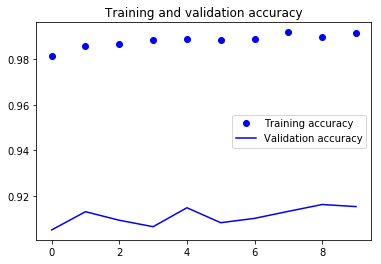

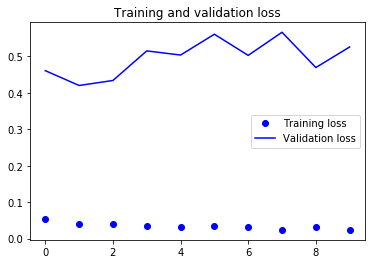

In [42]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [44]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.554145690318197
Test accuracy: 0.9109


In [45]:
predicted_classes = full_model.predict(test_data)

In [46]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [47]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9105 correct labels


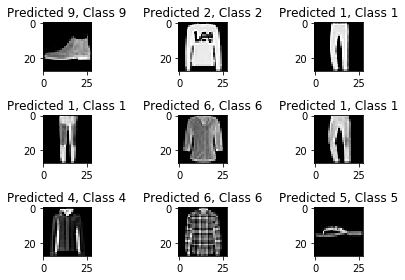

In [51]:
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels" %len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()